<a href="https://colab.research.google.com/github/georgezefko/Anomaly-Detection-for-Sequential-Data/blob/main/VAReE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import numpy as np
import torch
from torch import nn, optim
from torch import distributions
from torch.utils.data import DataLoader, TensorDataset

from torch.autograd import Variable
import os
import numpy as np
from random import randint
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import copy
from torch.nn.parameter import Parameter
import math
from torch.nn import functional as F
import seaborn as sns


In [3]:

#Heartbeat data - getting good results
data_train = np.loadtxt('/content/drive/MyDrive/AdvancedML/data/ECG5000/ECG5000_TRAIN', delimiter=',')
data_test_val = np.loadtxt('/content/drive/MyDrive/AdvancedML/data/ECG5000/ECG5000_TEST', delimiter=',')[:-1]

#Gun motion data- very bad results could be due to low amount of data
# data_train = np.loadtxt('/content/drive/MyDrive/AdvancedML/data/GunPointAgeSpan/GunPointAgeSpan_TRAIN.txt')
# data_test_val = np.loadtxt('/content/drive/MyDrive/AdvancedML/data/GunPointAgeSpan/GunPointAgeSpan_TEST.txt')

#Modestrain data- quite good results
# data_train = np.loadtxt('/content/drive/MyDrive/AdvancedML/data/MoteStrain/MoteStrain_TRAIN.txt')
# data_test_val = np.loadtxt('/content/drive/MyDrive/AdvancedML/data/MoteStrain/MoteStrain_TEST.txt')


In [ ]:
data_test_val.shape

(4499, 141)

In [4]:
#concatenate both in order to have more data
data = np.concatenate((data_train, data_test_val), axis=0)


In [ ]:
data

array([[ 1.     , -0.11252, -2.8272 , ...,  0.12343,  0.92529,  0.19314],
       [ 1.     , -1.1009 , -3.9968 , ...,  0.77382,  1.1196 , -1.4362 ],
       [ 1.     , -0.56709, -2.5935 , ...,  0.3211 ,  0.90423, -0.4218 ],
       ...,
       [ 2.     , -0.5477 , -1.8895 , ...,  1.2613 ,  1.1504 ,  0.80493],
       [ 2.     , -1.3518 , -2.209  , ..., -2.26   , -1.5778 , -0.68453],
       [ 2.     , -1.1244 , -1.905  , ..., -0.44331, -0.55977,  0.10857]])

In [5]:
df = pd.DataFrame(data)
new_columns = list(df.columns)
new_columns[0] = 'target'
df.columns = new_columns
df.target = [int(i) for i in df.target]

In [ ]:
df.target.value_counts()

1    5546
2    3356
4     369
3     182
5      46
Name: target, dtype: int64

In [6]:
normal_df = df[df.target == 1].drop(labels='target', axis=1)
normal_df.shape

(5546, 140)

In [7]:
anomaly_df = df[df.target != 1].drop(labels='target', axis=1)
anomaly_df.shape

(3953, 140)

In [ ]:
# normal = pd.read_csv('/content/drive/MyDrive/AdvancedML/data/normal_df.csv')
# anomaly = pd.read_csv('/content/drive/MyDrive/AdvancedML/data/anomaly_df.csv')

In [8]:
RANDOM_SEED = 42
train_df, val_df = train_test_split(normal_df,test_size=0.15,random_state=RANDOM_SEED)

val_df, test_df = train_test_split(val_df,test_size=0.33,random_state=RANDOM_SEED)

In [9]:
def create_dataset(df):

  sequences = df.astype(np.float32).to_numpy().tolist()

  dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]

  n_seq, seq_len, n_features = torch.stack(dataset).shape

  return dataset, seq_len, n_features

In [10]:
train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
test_normal_dataset, _, _ = create_dataset(test_df)
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, latent_features, dropout, latent_dim):

    super(Encoder,self).__init__()


    self.seq_len = seq_len
    self.n_features = n_features
    self.latent_dim = latent_dim
    self.hidden_dim = 2 * latent_dim
    self.latent_features = latent_features


    # self.rnn1 = nn.GRU( input_size=self.n_features, hidden_size=self.hidden_dim, dropout = dropout, num_layers=1,batch_first=True)
    # self.rnn2 = nn.GRU( input_size=self.hidden_dim, hidden_size= self.latent_dim, dropout = dropout, num_layers=1, batch_first=True)
    self.rnn1 = nn.LSTM( input_size=self.n_features, hidden_size=self.hidden_dim, dropout = dropout, num_layers=1,batch_first=True, bidirectional = False)
    self.rnn2 = nn.LSTM( input_size=self.hidden_dim, hidden_size= self.latent_dim, dropout = dropout, num_layers=1, batch_first=True, bidirectional = False)

    self.fc = nn.Linear(self.latent_dim, self.hidden_dim )

    self.mu = nn.Linear(self.hidden_dim, self.latent_features)
    self.var = nn.Linear(self.hidden_dim, self.latent_features)


  def forward(self, x):
    
    x = x.reshape((1, self.seq_len, self.n_features))

    # h0 = torch.zeros(1, x.size(0), self.hidden_dim) #GRU

    # out, _ = self.rnn1(x, h0) #GRU

    # out, hidden_n = self.rnn2(out) #GRU
    
    x, (_, _) = self.rnn1(x)
    
    x, (hidden_n, _) = self.rnn2(x)
    
    hidden = self.fc(hidden_n.reshape((self.n_features, self.latent_dim)))

    z_mu = self.mu(hidden)
    z_var = self.var(hidden)

    return z_mu, z_var



In [13]:

class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim, n_features,dropout):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    # self.rnn1 = nn.GRU(input_size=self.input_dim,hidden_size=self.input_dim, dropout = dropout,num_layers=1,batch_first=True)
    # self.rnn2 = nn.GRU(input_size=self.input_dim,hidden_size=self.hidden_dim,dropout=dropout,num_layers=1,batch_first=True)

    self.rnn1 = nn.LSTM(input_size=self.input_dim,hidden_size=self.input_dim, dropout = dropout,num_layers=1,batch_first=True, bidirectional = False)
    self.rnn2 = nn.LSTM(input_size=self.input_dim,hidden_size=self.hidden_dim,dropout=dropout,num_layers=1,batch_first=True, bidirectional = False)


    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

In [14]:
class Rencoder(nn.Module):

  def __init__(self, seq_len, n_features, latent_features, dropout, latent_dim):

    super(Rencoder,self).__init__()


    self.seq_len = seq_len
    self.n_features = n_features
    self.latent_dim = latent_dim
    self.hidden_dim = 2 * latent_dim
    self.latent_features = latent_features


    # self.rnn1 = nn.GRU( input_size=self.n_features, hidden_size=self.hidden_dim, dropout = dropout, num_layers=1,batch_first=True)
    # self.rnn2 = nn.GRU( input_size=self.hidden_dim, hidden_size= self.latent_dim, dropout = dropout, num_layers=1, batch_first=True)
    self.rnn1 = nn.LSTM( input_size=self.n_features, hidden_size=self.hidden_dim, dropout = dropout, num_layers=1,batch_first=True, bidirectional = False)
    self.rnn2 = nn.LSTM( input_size=self.hidden_dim, hidden_size= self.latent_dim, dropout = dropout, num_layers=1, batch_first=True, bidirectional = False)

    self.fc = nn.Linear(self.latent_dim, self.hidden_dim )

    self.mu = nn.Linear(self.hidden_dim, self.latent_features)
    self.var = nn.Linear(self.hidden_dim, self.latent_features)


  def forward(self, x):
    
    x = x.reshape((1, self.seq_len, self.n_features))

    # h0 = torch.zeros(1, x.size(0), self.hidden_dim) #GRU

    # out, _ = self.rnn1(x, h0) #GRU

    # out, hidden_n = self.rnn2(out) #GRU
    
    x, (_, _) = self.rnn1(x)
    
    x, (hidden_n, _) = self.rnn2(x)
    
    hidden = self.fc(hidden_n.reshape((self.n_features, self.latent_dim)))

    z_mu = self.mu(hidden)
    z_var = self.var(hidden)

    return z_mu, z_var



In [15]:
class VAE(nn.Module):

  def __init__(self, enc,dec,rec, latent_features,latent_dim):

    super(VAE,self).__init__()

  
    self.enc = enc
    self.fc= nn.Linear(latent_features, latent_dim)
    self.dec = dec
    self.rec = rec
    

  def forward(self, x):

    z_mu, z_var = self.enc(x)


    #reparameterization
    std = torch.exp(z_var / 2)
    eps = torch.randn_like(std)
    x_sample = eps.mul(std).add_(z_mu)

    x = self.fc(x_sample)
    x = self.dec(x)    

    x_hat = x.unsqueeze(-1)
    x_hat = torch.mean(x_hat, dim=1)

    ##Re-encoder
    mu_rec, var_rec = self.rec(x_hat)
    #reparameterization
    std_rec = torch.exp(var_rec / 2)
    eps_rec = torch.randn_like(std_rec)
    z_sample = eps.mul(std).add_(mu_rec)
    return x_hat, z_mu, z_var ,x_sample, mu_rec,var_rec,z_sample #{'output': output, 'att': att}

In [16]:
latent_features = 10
dropout = 0.2
latent_dim = 64
input_dim = 64



# encoder
encoder = Encoder(seq_len, n_features, latent_features, dropout, latent_dim)

# decoder
decoder = Decoder(seq_len, input_dim, n_features,dropout)

#re-encoder
rencoder = Rencoder(seq_len, n_features, latent_features, dropout, latent_dim)

# vae
model = VAE(encoder,decoder, rencoder, latent_features, latent_dim).to(device)

print(model)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


VAE(
  (enc): Encoder(
    (rnn1): LSTM(1, 128, batch_first=True, dropout=0.2)
    (rnn2): LSTM(128, 64, batch_first=True, dropout=0.2)
    (fc): Linear(in_features=64, out_features=128, bias=True)
    (mu): Linear(in_features=128, out_features=10, bias=True)
    (var): Linear(in_features=128, out_features=10, bias=True)
  )
  (fc): Linear(in_features=10, out_features=64, bias=True)
  (dec): Decoder(
    (rnn1): LSTM(64, 64, batch_first=True, dropout=0.2)
    (rnn2): LSTM(64, 128, batch_first=True, dropout=0.2)
    (output_layer): Linear(in_features=128, out_features=1, bias=True)
  )
  (rec): Rencoder(
    (rnn1): LSTM(1, 128, batch_first=True, dropout=0.2)
    (rnn2): LSTM(128, 64, batch_first=True, dropout=0.2)
    (fc): Linear(in_features=64, out_features=128, bias=True)
    (mu): Linear(in_features=128, out_features=10, bias=True)
    (var): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [17]:
optimizer = optim.Adam(model.parameters(), lr=0.0006796395231964973) # lr derived from optimazation method

cuda = torch.cuda.is_available()


In [18]:
x =train_dataset[0].to(device)

if cuda:
    x = x.cuda()

outputs = model(x)
x_hat,z_mu,z_var,x_sample,mu_rec,var_rec,z_sample = outputs

print(z_mu.shape)
print(z_var.shape)
print(x_hat.shape)
print(x_sample.shape)
print(mu_rec.shape)
print(var_rec.shape)
print(z_sample.shape)


torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([140, 1])
torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([1, 10])


In [19]:
def loss(X, x_hat, z_mu, z_var, x_sample, rec_mu, rec_var, z_sample,criterion):

  if criterion == 'MSELoss':
    criterion = nn.MSELoss(size_average=False)
  elif criterion == 'SmoothL1Loss':
    criterion = nn.SmoothL1Loss(size_average=False)

  recon_loss = criterion(x_hat, X)
  latent_loss = criterion(x_sample, z_sample)

  KL_loss = -0.5 * torch.mean(1 + z_var - z_mu**2 - torch.exp(z_var))
  KL_latent = -0.5 * torch.mean(1 + rec_var - rec_mu**2 - torch.exp(rec_var))

  elbo_loss = recon_loss + KL_loss
  total_loss = recon_loss + KL_loss + latent_loss + KL_latent
  return total_loss, elbo_loss, KL_loss

In [20]:
def train():

  model.train()

  train_loss = []
  train_kl = []
  train_total = []
  

  for X in train_dataset:

    
    X = X.to(device)

    optimizer.zero_grad()

    x_hat, z_mu, z_var, x_sample, rec_mu, rec_var, z_sample = model(X)

    total_loss, elbo_loss, KL_loss = loss(X, x_hat, z_mu, z_var, x_sample, rec_mu, rec_var, z_sample,criterion='SmoothL1Loss')

    total_loss.backward()

    train_loss.append(elbo_loss.item())
    train_kl.append(KL_loss.item())
    train_total.append(total_loss.item())

    optimizer.step()
  
  train_elbo_loss = np.mean(train_loss)
  train_kl_loss = np.mean(train_kl)
  train_total_loss = np.mean(train_total)

  return train_total_loss, train_elbo_loss,train_kl_loss



In [24]:
def test():

  model.eval()

  with torch.no_grad():
    test_loss = []
    test_kl = []
    test_total = []
    for x in val_dataset:
     
      x = x.to(device)
      x_hat, z_mu, z_var, x_sample, rec_mu, rec_var, z_sample = model(x)
      total_loss, elbo_loss, KL_loss = loss(x, x_hat, z_mu, z_var, x_sample, rec_mu, rec_var, z_sample,criterion='SmoothL1Loss')

      test_loss.append(elbo_loss.item())
      test_kl.append(KL_loss.item())
      test_total.append(total_loss.item())

  test_elbo_loss = np.mean(test_loss)
  test_kl_loss = np.mean(test_kl)
  test_total_loss = np.mean(test_total)

  return model.eval(),test_total_loss, test_elbo_loss,test_kl_loss

In [22]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [25]:
epochs = 20

best_model_wts = copy.deepcopy(model.state_dict())
best_loss = 10000.0
history_elbo = dict(train_elbo=[], test_elbo=[])
history_kl = dict(train_kl=[], test_kl=[])
history_total = dict(train_total = [], test_total= [])

device = torch.device("cuda:0" if cuda else "cpu")
print("Using device:", device)

for e in range(epochs):

  start_time = time.time()

  train_total_loss, train_elbo_loss, train_kl_loss = train()
  model, test_total_loss, test_elbo_loss, test_kl_loss  = test()

  end_time = time.time()

  epoch_mins, epoch_secs = epoch_time(start_time, end_time)

  if best_loss > test_elbo_loss:
    best_test_loss = test_elbo_loss
    best_model_wts = copy.deepcopy(model.state_dict())

  print(f'Epoch: {e+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'\t train total loss {train_total_loss} | train elbo loss {train_elbo_loss} | train kl loss {train_kl_loss}') 
  print(f'\t val total loss {test_total_loss}    | val elbo loss {test_elbo_loss}    | valid kl loss {test_kl_loss}') 


  history_elbo['train_elbo'].append(train_elbo_loss)
  history_elbo['test_elbo'].append(test_elbo_loss)

  history_kl['train_kl'].append(train_kl_loss)
  history_kl['test_kl'].append(test_kl_loss)

  history_total['train_total'].append(train_total_loss)
  history_total['test_total'].append(test_total_loss)


Using device: cuda:0


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch: 01 | Epoch Time: 2m 12s
	 train total loss 20.659212000652243 | train elbo loss 20.52672377804047 | train kl loss 0.15717680115702393
	 val total loss 20.112785895808166    | val elbo loss 20.000049587640127    | valid kl loss 0.19880814029027571
Epoch: 02 | Epoch Time: 2m 12s
	 train total loss 19.141284907020953 | train elbo loss 19.04876449465195 | train kl loss 0.22023434462211472
	 val total loss 17.092183936648137    | val elbo loss 16.988683998477736    | valid kl loss 0.22085498899381936
Epoch: 03 | Epoch Time: 2m 12s
	 train total loss 13.940262344007934 | train elbo loss 13.854951647817963 | train kl loss 0.24385406393150802
	 val total loss 10.208624969478997    | val elbo loss 10.141168789974877    | valid kl loss 0.2946357776542968
Epoch: 04 | Epoch Time: 2m 7s
	 train total loss 9.963113609162438 | train elbo loss 9.890732985509873 | train kl loss 0.25784258489758977
	 val total loss 10.63442141449002    | val elbo loss 10.578960702492047    | valid kl loss 0.22980

In [26]:
# save the model
MODEL_PATH = 'model.pth'
torch.save(model, MODEL_PATH)

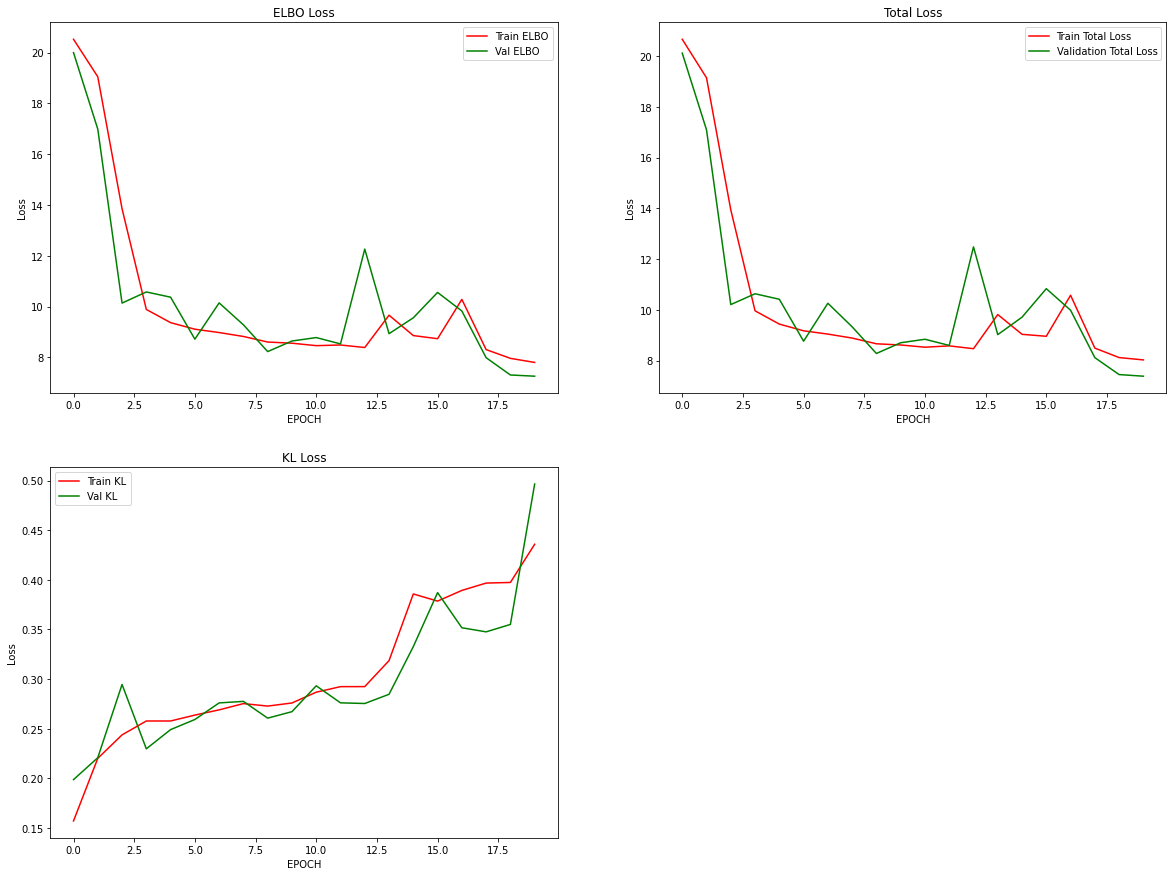

In [27]:
fig = plt.figure(figsize=(20,15))


fig.add_subplot(2,2,1)
plt.plot(list(range(0,len(history_elbo['train_elbo']))), history_elbo['train_elbo'],'r')
plt.plot(list(range(0,len(history_elbo['test_elbo']))), history_elbo['test_elbo'],'g')
plt.legend(['Train ELBO','Val ELBO'])
plt.xlabel('EPOCH')
plt.ylabel('Loss')
plt.title('ELBO Loss')



fig.add_subplot(2,2,2)
plt.plot(list(range(0,len(history_total['train_total']))), history_total['train_total'], 'r')
plt.plot(list(range(0,len(history_total['test_total']))), history_total['test_total'],'g')
plt.legend(['Train Total Loss','Validation Total Loss'])
plt.xlabel('EPOCH')
plt.ylabel('Loss')
plt.title('Total Loss')



fig.add_subplot(2,2, 3)
plt.plot(list(range(0,len(history_kl['train_kl']))), history_kl['train_kl'], 'r')
plt.plot(list(range(0,len(history_kl['test_kl']))), history_kl['test_kl'],'g')
plt.legend(['Train KL','Val KL'])
plt.xlabel('EPOCH')
plt.ylabel('Loss')
plt.title('KL Loss')





plt.show();



In [30]:
def predict(model, dataset):
  predictions, elbo_losses, total_losses = [], [],[]
  with torch.no_grad():
    model = model.eval()
    for x in dataset:
        x = x.to(device)
        
        x_hat, z_mu, z_var,x_sample, rec_mu, rec_var, z_sample = model(x)
        total_loss, elbo_loss, KL_loss = loss(x, x_hat, z_mu, z_var, x_sample, rec_mu, rec_var, z_sample,criterion='SmoothL1Loss')
       
        elbo_losses.append(elbo_loss.item())
        total_losses.append(total_loss.item())
        predictions.append(x_hat.cpu().numpy().flatten())
  return predictions, elbo_losses,total_losses

In [31]:
#prediction on normal train dataset
predict_train, total_elbo_losses_train, total_losses = predict(model, train_dataset)

#prediction on test normal dataset
predict_test, elbo_losses_test, total_losses_test = predict(model,test_normal_dataset)

#prediction on anomaly test dataset
predict_anomaly, elbo_losses_anomaly, total_losses_anomaly = predict(model,test_anomaly_dataset)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [32]:
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, confusion_matrix


In [33]:
label = np.concatenate((np.ones(len(total_losses_test)),np.zeros(len(total_losses_test))))
total_losses = np.concatenate((total_losses_test,np.random.choice(total_losses_anomaly, len(total_losses_test),replace=True)),axis=0)
error_df = pd.DataFrame({'Reconstruction_error': total_losses,'Label':label})
#error_df = error_df.sample(frac=1)
error_df.head(5)

,Reconstruction_error,Label
0,4.919977,1.0
1,5.256355,1.0
2,3.736126,1.0
3,4.594957,1.0
4,13.535640,1.0


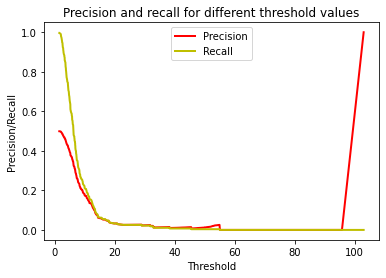

In [34]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.Label, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:],'r', label="Precision",linewidth=2)
plt.plot(threshold_rt, recall_rt[1:],'y', label="Recall",linewidth=2)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [35]:
threshold_fixed = 20

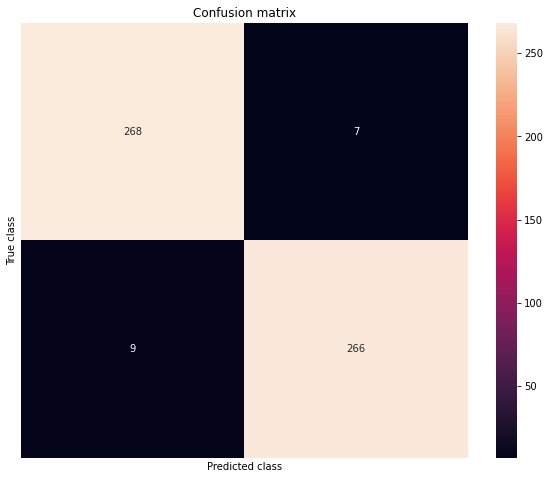

In [36]:
pred_y = [0 if e > threshold_fixed else 1 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.Label, pred_y)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, xticklabels=[], yticklabels=[], annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()


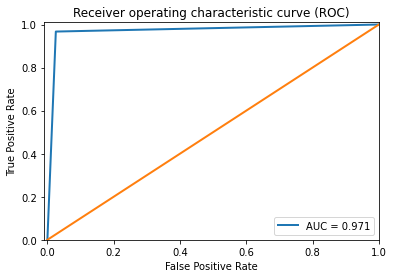

In [37]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.Label, pred_y)
roc_auc = auc(false_pos_rate, true_pos_rate,)
plt.plot(false_pos_rate, true_pos_rate, linewidth=2, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=2)
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [38]:
def plot_prediction(data, model, title, ax):
  predictions, elbo_losses,total_losses = predict(model, [data])

  ax.plot(data,'r', label='true')
  ax.plot(predictions[0], 'b',label='reconstructed')
  ax.set_title(f'{title} (Total loss: {np.around(total_losses[0], 2)})')
  ax.legend()

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(r

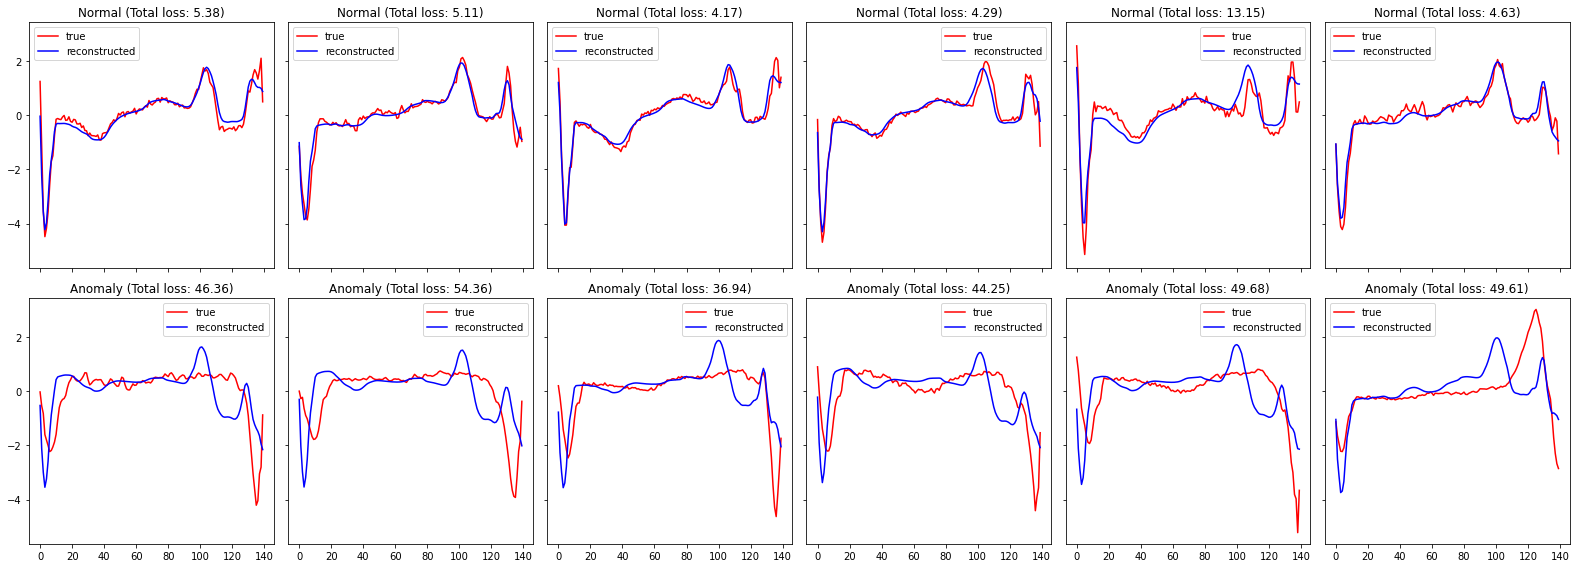

In [39]:
fig, axs = plt.subplots(nrows=2,ncols=6,sharey=True,sharex=True,figsize=(22, 8))

for i, data in enumerate(test_normal_dataset[:6]):
  plot_prediction(data, model, title='Normal', ax=axs[0, i])

for i, data in enumerate(test_anomaly_dataset[:6]):
  plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

fig.tight_layout();